In [73]:
from sttn.data.lehd import OriginDestinationEmploymentDataProvider

provider = OriginDestinationEmploymentDataProvider()
state_network = provider.get_data(state='oh', year=2018)

<AxesSubplot:>

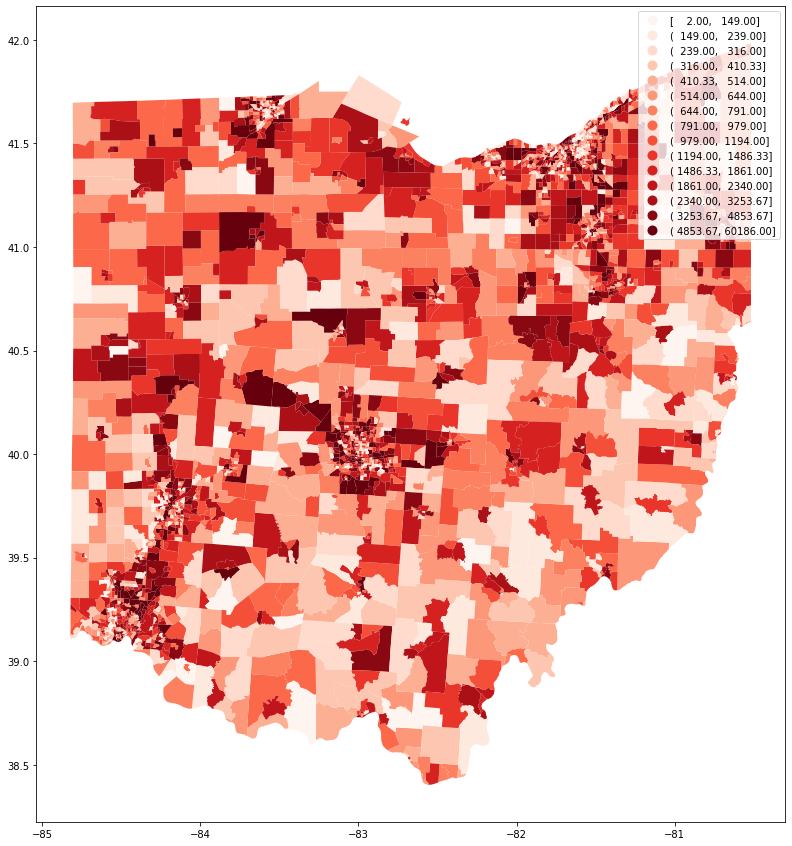

In [74]:
residence_sum = state_network.agg_adjacent_edges(aggs={'S000':'sum'}, outgoing=False).rename(columns={'S000':'total_jobs'})
with_residence = state_network.join_node_labels(residence_sum)
with_residence.plot(figsize=(15,15), column='total_jobs', cmap="Reds", scheme='quantiles', k=15, legend=True)

<AxesSubplot:>

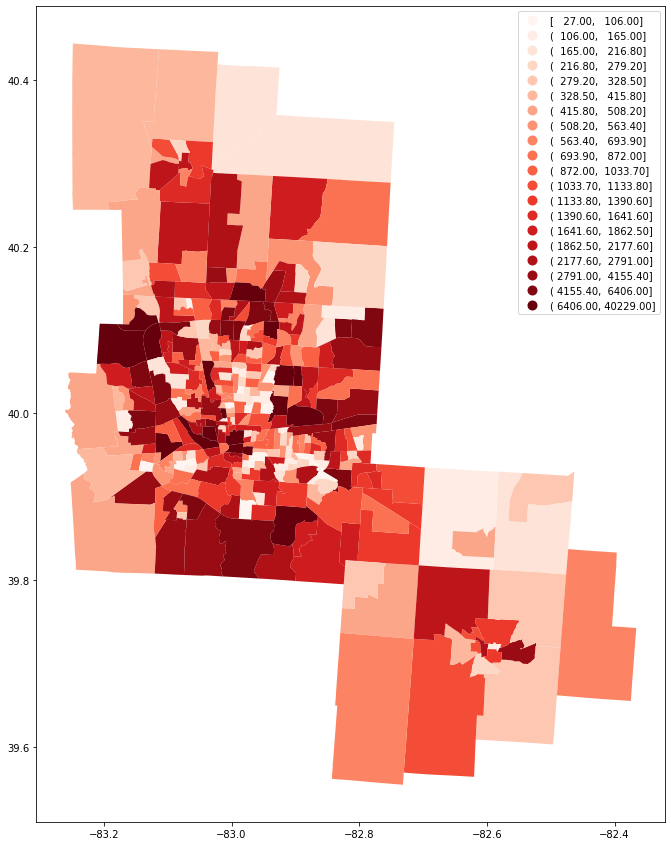

In [75]:
NYC = ['New York County, NY', 'Queens County, NY','Kings County, NY','Bronx County, NY','Richmond County, NY']
bay_area = ['San Francisco County, CA', 'San Mateo County, CA', 'Santa Clara County, CA', 'Alameda County, CA', 'Marin County, CA', 'Contra Costa County, CA']
boston = ['Suffolk County, MA']
phila=['Philadelphia County, PA']
sj = ['Santa Clara County, CA']
sf = ['San Francisco County, CA']
seattle = ['King County, WA']
atlanta = ['Fulton County, GA']
la = ['Los Angeles County, CA']
miami = ['Miami-Dade County, FL']
austin = ['Travis County, TX']
chicago = ['Cook County, IL']
indianapolis = ['Marion County, IN']
portland = ['Multnomah County, OR']
salt_lake = ['Salt Lake County, UT']
vegas = ['Clark County, NV']
detroit = ['Wayne County, MI']
minneapolis = ['Hennepin County, MN']
milwaukee = ['Milwaukee County, WI']
columbus=['Delaware County, OH','Fairfield County, OH', 'Franklin County, OH']
census_network = state_network.filter_nodes(state_network.node_labels.county.isin(columbus))
census_network_sum = census_network.agg_adjacent_edges(aggs={'S000':'sum'}, outgoing=False).rename(columns={'S000':'total_jobs'})
census_network_with_residence = census_network.join_node_labels(census_network_sum)
census_network_with_residence.plot(figsize=(15,15), column='total_jobs', cmap="Reds", scheme='quantiles', k=20, legend=True)

In [76]:
county_network = census_network.group_nodes('zip')
county_network = county_network.agg_parallel_edges(column_aggs={'S000': 'sum', 'SE01': 'sum', 'SE02': 'sum', 'SE03': 'sum'})
#fdf = county_network.to_flow_date_frame(flow='S000')
#fdf.plot_flows(flow_color='red')

In [56]:
network_with_jobs = compute_jobs(county_network, 'S000')
fdf = network_with_jobs.to_flow_date_frame(flow='S000')
gravity_singly_fitted=fit_gravity_model(fdf, 'power_law')
print(Gravity(gravity_type='singly constrained'))
print(gravity_singly_fitted)
gravity_fdf_fitted = gravity_singly_fitted.generate(network_with_jobs.node_labels.reset_index(),
                                            tile_id_column='id',
                                            tot_outflows_column='outflow',
                                            relevance_column= 'jobs',
                                            out_format='flows').rename(columns={'flow': 'gravity_flow_fitted'})

100%|██████████| 68/68 [00:00<00:00, 20700.59it/s]

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="singly constrained")
Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-0.9117762515385952], origin_exp=1.0, destination_exp=1.0055350359302713, gravity_type="singly constrained")



/Users/user/.local/share/virtualenvs/sttn-CIAb_6sA/lib/python3.8/site-packages/skmob/models/gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)


In [9]:
compare_performance(fdf, gravity_fdf_fitted)

67.03009438892724
                     flow_expected  gravity_flow_fitted
flow_expected             1.000000             0.938203
gravity_flow_fitted       0.938203             1.000000


In [77]:
extract_model_weights(county_network)

{'SE01': -0.8704694193421091,
 'SE02': -0.8444666922007927,
 'SE03': -0.786384116311603}

<AxesSubplot:xlabel='cities'>

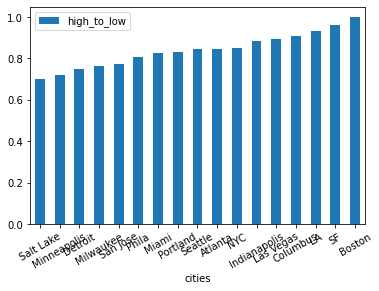

In [80]:
import matplotlib.pyplot as plt
import pandas as pd

cities= [
    'NYC','Phila','San Jose','Atlanta','LA','Miami','SF','Boston','Seattle','Indianapolis','Portland',
    'Salt Lake', 'Las Vegas', 'Detroit', 'Minneapolis', 'Milwaukee', 'Columbus'
]
low = [-1.043, -0.8, -0.87, -0.97, -1.32, -0.91, -0.49, -0.79, -1.15, -0.78, -0.82, -0.77, -0.65, -1.07, -1.06, -0.71, -0.87]
high = [-0.887, -0.645, -0.67, -0.82, -1.23, -0.75, -0.47, -0.79, -0.97, -0.69, -0.68, -0.54, -0.58, -0.8, -0.76, -0.54, -0.79]
df = pd.DataFrame({'cities':cities, 'low':low, 'high':high})

#plt.scatter(low, high)
#plt.xlabel("low-income exp")
#plt.ylabel("high-income exp")
#plt.show()
df['high_to_low'] = df.high / df.low
df['high_minus_low'] = df.high - df.low

df.sort_values('high_to_low').plot.bar(x='cities', y='high_to_low', rot=30)

In [26]:
from sttn.utils import add_distance

dist = add_distance(census_network)
dist_od = add_od_jobs(dist, 'S000')
dist_od.edges_df['coef'] = 1.0* dist_od.edges_df['from_residents']*dist_od.edges_df['to_jobs']
dist_od.edges_df['num'] = dist_od.edges_df['S000']*dist_od.edges_df['coef']
dist_od.edges_df['denum'] = dist_od.edges_df['coef']*dist_od.edges_df['coef']

NameError: name 'census_network' is not defined

<AxesSubplot:xlabel='distance', ylabel='f(d)'>

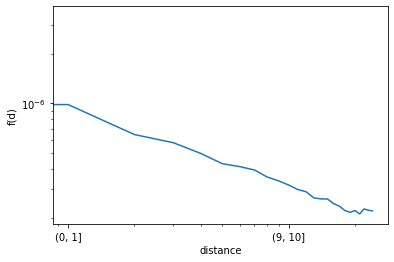

In [173]:
bins = list(range(0, 25, 1))
grouped = dist_od.edges_df.groupby(pd.cut(dist_od.edges_df.distance, bins)).sum()[['num', 'denum']]
grouped['fd'] = grouped['num']/grouped['denum']
grouped['fd'].plot(loglog=True,ylabel='f(d)')

<AxesSubplot:xlabel='distance', ylabel='log(f(d))'>

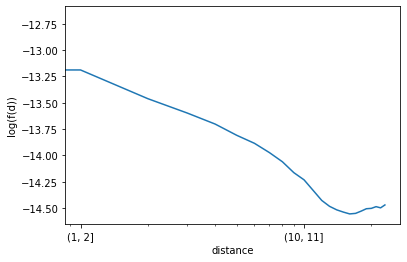

In [170]:
import numpy as np
filtered = dist_od.edges_df[dist_od.edges_df.from_residents > 0].copy()
filtered['ln_coef'] = np.log(filtered['S000']) - np.log(filtered['from_residents']) - np.log(filtered['to_jobs'])
grouped_ln = filtered.groupby(pd.cut(filtered.distance, bins)).mean()[['ln_coef']]
grouped_ln['ln_coef'].plot(ylabel='log(f(d))', logx=True)


In [21]:
# generate synthetics flows
import numpy as np
np.random.seed(0)

gravity_fdf = Gravity(gravity_type='singly constrained').generate(network_with_jobs.node_labels.reset_index(),
                                            tile_id_column='id',
                                            tot_outflows_column='outflow',
                                            relevance_column= 'jobs',
                                            out_format='flows').rename(columns={'flow': 'gravity_flow'})

gravity_fdf_fitted

100%|██████████| 62/62 [00:00<00:00, 12250.76it/s]
/Users/user/.local/share/virtualenvs/sttn-CIAb_6sA/lib/python3.8/site-packages/skmob/models/gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)
100%|██████████| 62/62 [00:00<00:00, 17275.42it/s]


,origin,destination,gravity_flow_fitted
0,"Albany County, NY","Allegany County, NY",4.718482
1,"Albany County, NY","Bronx County, NY",1218.264685
2,"Albany County, NY","Broome County, NY",655.113784
3,"Albany County, NY","Cattaraugus County, NY",3.325564
4,"Albany County, NY","Cayuga County, NY",79.150221
...,...,...,...
3777,"Yates County, NY","Warren County, NY",2.890166
3778,"Yates County, NY","Washington County, NY",0.797611
3779,"Yates County, NY","Wayne County, NY",133.202524
3780,"Yates County, NY","Westchester County, NY",13.655760


In [117]:
from skmob.models.gravity import compute_distance_matrix
import numpy
import pandas as pd

spatial_tessellation = county_network_with_jobs.node_labels.reset_index()
n_locs = len(spatial_tessellation)
origins = np.arange(n_locs)
distance_matrix = compute_distance_matrix(spatial_tessellation, origins)
spatial_tessellation[['id', 'outflow', 'jobs']].to_csv('~/data/node_descr.csv', index=False)
pd.DataFrame(distance_matrix).to_csv('~/data/distance_matrix.csv', index=False)


100%|██████████| 186/186 [00:00<00:00, 2664.26it/s]


In [253]:
# Radiation model
from skmob.models import Radiation
radiation = Radiation()
np.random.seed(0)

radiation_fdf = radiation.generate(county_network_with_jobs.node_labels.reset_index(), 
                                tile_id_column='id',  
                                tot_outflows_column='outflow', 
                                relevance_column='jobs', 
                                out_format='flows').rename(columns={'flow': 'radiation_flow'})

radiation_fdf

100%|██████████| 186/186 [00:00<00:00, 775.30it/s]


,origin,destination,radiation_flow
0,10001,10018,1551.0
1,10001,10011,2564.0
2,10001,10036,1691.0
3,10001,10016,503.0
4,10001,10177,142.0
...,...,...,...
17455,11697,11224,1.0
17456,11697,11210,1.0
17457,11697,11230,1.0
17458,11697,11236,1.0


In [17]:
import math
import pandas as pd
from sttn.network import SpatioTemporalNetwork
from sklearn.metrics import mean_squared_error
from skmob.models import Gravity


def fit_gravity_model(fdf, deterrence='power_law'):
    gravity_singly_fitted = Gravity(gravity_type='singly constrained', deterrence_func_type=deterrence)
    gravity_singly_fitted.fit(fdf, relevance_column='jobs')
    return gravity_singly_fitted

def compare_performance(expected_fdf, generated_fdf):
    filtered = expected_fdf[expected_fdf.origin != expected_fdf.destination].rename(columns={'flow': 'flow_expected'})
    merged = filtered.merge(generated_fdf, how='outer', on=['origin', 'destination']).fillna(0)
    
    print(math.sqrt(mean_squared_error(merged.flow_expected,merged.gravity_flow_fitted)))
    print(merged.reset_index()[['flow_expected', 'gravity_flow_fitted']].corr())

def add_od_jobs(network: SpatioTemporalNetwork, job_column: str) -> SpatioTemporalNetwork:
    comp_aggs={job_column: 'sum'}
    jobs = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=False).rename(columns={job_column: 'jobs'})
    residents = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=True).rename(columns={job_column: 'residents'})
    
    mapped_from = network.edges_df.join(residents, on='from').rename(columns={'residents': 'from_residents'})
    mapped_from['from_residents'] = mapped_from['from_residents'].fillna(0)
    mapped_all = mapped_from.join(jobs, on='to').rename(columns={'jobs': 'to_jobs'})
    return SpatioTemporalNetwork(mapped_all, network.node_labels)

def compute_jobs(network, job_column):
    comp_aggs={job_column: 'sum'}
    jobs = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=False).rename(columns={job_column: 'jobs'})
    outflow = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=True, include_cycles=False).rename(columns={job_column: 'outflow'})
    with_jobs = network.join_node_labels(jobs).join_node_labels(outflow)
    return with_jobs

def extract_model_weights(network):
    columns = ['SE01', 'SE02', 'SE03']
    result = {}
    for column in columns:
        with_jobs = compute_jobs(network, column)
        fdf = with_jobs.to_flow_date_frame(flow=column)
        model = fit_gravity_model(fdf)
        result[column] = model.deterrence_func_args[0]
    
    return result

In [37]:
merged_gravity_comp = nyc_filtered.merge(gravity_fdf_fitted_se01, how='outer', on=['origin', 'destination']).fillna(0)
merged_gravity_comp = merged_gravity_comp.merge(gravity_fdf_fitted_se02, how='outer', on=['origin', 'destination']).fillna(0)
comp = merged_gravity_comp.merge(gravity_fdf_fitted_se03, how='outer', on=['origin', 'destination']).fillna(0)
comp['all'] = comp.gravity_flow_se01 + comp.gravity_flow_se02 + comp.gravity_flow_se03
comp[['flow_expected', 'all']].corr()

,flow_expected,all
flow_expected,1.000000,0.928555
all,0.928555,1.000000


In [184]:
# merged_all.sum()
compression_opts = dict(method='zip',
                        archive_name='nyc_census_tract_flows.csv')
#merged_all.to_csv('~/data/flows_new.csv', index=False)
dist_od.edges_df.sum()
#dist_od.edges_df[['from', 'to', 'S000', 'distance', 'from_residents', 'to_jobs']].to_csv('~/data/nyc_census_tract_flows.zip', index=False, compression=compression_opts)

from              3.521902e+16
to                3.522067e+16
S000              3.236414e+06
SA01              7.714890e+05
SA02              1.794709e+06
SA03              6.702160e+05
SE01              6.073250e+05
SE02              9.610450e+05
SE03              1.668044e+06
SI01              1.563520e+05
SI02              4.998160e+05
SI03              2.580246e+06
distance          1.123511e+07
from_residents    1.616086e+09
to_jobs           4.520900e+09
coef              7.170111e+12
num               8.910745e+13
denum             2.559800e+20
dtype: float64